# Библиотека BigARTM для тематического моделирования
## Для Bigartm v0.8.0 (с поправками для 0.8.2)

Импортируем BigARTM:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [3]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [5]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1)
# число после названия модальностей - это их веса

Создаем словарь и инициализируем модель с его помощью

In [6]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [28]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                           dictionary='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

In [10]:
model_artm.initialize('dictionary')

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [11]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

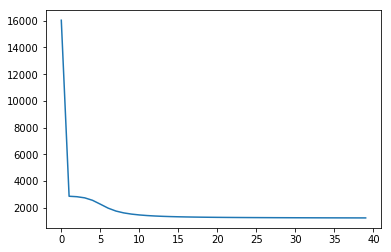

In [12]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [13]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  право быть который человек ребенок язык они также семья это являться как для свой мочь
sbj1:  что свой который быть это герой его этот человек они она ребенок как жизнь такой
sbj2:  предложение слово который что это например быть как сила или такой речь они этот если
sbj3:  который что ядро энергия это вода этот земля быть масса атом как температура такой океан
sbj4:  пушкин поэт который что стихотворение это быть свой этот звук год весь его лирика такой
sbj5:  x быть a b число этот при функция уравнение что это для если ток который
sbj6:  человек который свой что жизнь его быть это герой как произведение литература этот для русский
sbj7:  который человек общество развитие социальный быть это как политический себя государство век культура жизнь для
sbj8:  страна государство который население быть территория этот год являться сша что время африка хозяйство также
sbj9:  быть который год государство война свой что становиться первый как весь время империя армия военный


посмотрим также на разреженность матриц:

In [14]:
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.75459345301
0.106092436975


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [15]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary=dictionary), overwrite=True)
#если мы хотим применять регуляризатор только к некоторым модальностям, указываем это в параметре class_ids: class_ids=["text"]

In [16]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [17]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  право быть который человек ребенок язык они семья также это являться для свой время русский
sbj1:  что свой который быть это герой человек его этот она жизнь они ребенок как такой
sbj2:  предложение слово который что это например быть как сила или такой речь они этот если
sbj3:  который что ядро энергия это вода этот земля быть масса атом как температура такой океан
sbj4:  пушкин поэт который что стихотворение быть свой это звук этот год весь его лирика произведение
sbj5:  x быть a b число этот при функция уравнение что это для если ток который
sbj6:  человек который свой что жизнь его быть это герой как произведение литература этот для русский
sbj7:  который человек общество развитие социальный быть как это политический государство себя культура жизнь век для
sbj8:  страна государство население который быть территория этот год являться африка время что хозяйство также сша
sbj9:  быть который год государство война свой что становиться первый как весь военный время империя армия


In [19]:
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.801751661594
0.285084033613


Попробуем менять коэффициент регуляризации:

In [20]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [21]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [22]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  право язык свобода семья гражданин английский правовой религиозный гражданский суд порядок орган честь will is
sbj1:  ребенок лермонтов поэма сказка отец молодой хороший сюжет любить гоголь комедия ничто романтизм жена эпос
sbj2:  слово предложение например случай работа простой предмет какой речь глагол физика скорость свет кто угол
sbj3:  земля энергия вода ядро масса количество природный океан атом движение температура частица заряд море располагать
sbj4:  пушкин поэт стихотворение звук лирика писать стих поэзия русь былина почти любовный бумага князь сравнение
sbj5:  x при a число если b функция тело два получать можно уравнение равный пример корень
sbj6:  человек свой его жизнь герой русский произведение мир литература история сам автор литературный личность писатель
sbj7:  общество век развитие социальный политический отношение процесс форма экономический производство культура характер система понятие роль
sbj8:  государство страна территория население город северный миров

In [23]:
# еще раз посмотрим на разреженность
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.900080750357
0.331512605042


разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [24]:
model_artm.save("my_model")

In [59]:
model_artm.load("my_model")

строим матрицы в чистом виде:

In [25]:
phi = model_artm.get_phi()

In [26]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
домохозяйка,0.00000,0.000000,0.000123,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
институт,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002557,0.000000,0.000000
машинка,0.00000,0.000000,0.000000,0.000000,0.000257,0.000000,0.000000,0.000000,0.000000,0.000000
прочий,0.00000,0.001465,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
навязнуть,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000102,0.000000,0.000000,0.000000
физиология,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000247,0.000000,0.000000
истязать,0.00024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
выборы,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000995
кндр,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000280,0.000000
федерализм,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000093,0.000000


Матрица вероятностей тем в документах.

In [27]:
theta = model_artm.get_theta()
theta

,100,101,102,103,104,105,106,107,108,109,...,290,291,292,293,294,295,296,297,298,299
sbj0,0.007722,0.000000,0.035433,0.000000,0.372402,0.006303,0.059761,0.000000,0.000000,0.010898,...,0.013043,0.387957,0.012500,0.013986,0.288813,0.000000,0.353583,0.049751,0.000000,0.005766
sbj1,0.007722,0.000000,0.074803,0.000000,0.097570,0.370327,0.019975,0.499679,0.004405,0.014460,...,0.033913,0.000000,0.017003,0.265384,0.066465,0.005263,0.006173,0.238806,0.005556,0.009390
sbj2,0.000000,0.000000,0.377679,0.000000,0.038688,0.012721,0.040075,0.031395,0.070485,0.026882,...,0.004392,0.000000,0.029167,0.043247,0.024649,0.000000,0.030488,0.064677,0.661111,0.046948
sbj3,0.023166,0.786325,0.031496,0.752688,0.057540,0.000000,0.107570,0.000000,0.638617,0.050056,...,0.000000,0.000000,0.569495,0.020979,0.015106,0.000000,0.000000,0.000000,0.138889,0.562309
sbj4,0.007722,0.000000,0.007874,0.000000,0.009346,0.162060,0.003984,0.013393,0.000000,0.005376,...,0.005262,0.000000,0.000000,0.223009,0.018381,0.000000,0.000000,0.054726,0.000000,0.000000
sbj5,0.000000,0.000000,0.039370,0.000000,0.051508,0.051428,0.063745,0.000000,0.251101,0.043011,...,0.000000,0.049751,0.000000,0.020979,0.033233,0.973684,0.000000,0.000000,0.194445,0.154930
sbj6,0.383967,0.000000,0.322835,0.000000,0.126168,0.212185,0.350597,0.388165,0.035392,0.123656,...,0.074199,0.000000,0.067059,0.369691,0.088181,0.021053,0.128049,0.358209,0.000000,0.065728
sbj7,0.281853,0.000000,0.086614,0.000000,0.079439,0.033710,0.079681,0.017857,0.000000,0.725660,...,0.073913,0.119403,0.216667,0.000000,0.066800,0.000000,0.481707,0.049751,0.000000,0.046948
sbj8,0.077905,0.213675,0.000000,0.247312,0.115936,0.014713,0.191180,0.000000,0.000000,0.000000,...,0.100000,0.074730,0.033847,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037559
sbj9,0.209943,0.000000,0.023895,0.000000,0.051402,0.136555,0.083431,0.049511,0.000000,0.000000,...,0.695279,0.368159,0.054262,0.042725,0.398372,0.000000,0.000000,0.184080,0.000000,0.070423


Если у нас будут новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [26]:
theta_test = model_artm.transform(batch_vectorizer)